# Exploring SAT Scores

The goal is to understand what demographic and education information affects students' SAT scores in NY public schools. Is the SAT a fair test? 

Each section within the SAT (Scholastic Aptitude Test) is worth a maximum of 800 points which combined makes for a total, perfect sctore o 2400 points. 

The following datasets will be combined to understand these relationships: 
*  SAT scores by school: SAT scores for each high school in NYC
*  School attendance: attendance information for each school in NYC
*  Class size: class size per school
*  AP test results: Advanced Placement (AP) exam results for each high school 
*  Graduation outcomes: the percentage of students who graduated and other outcome information
*  Demographics: demographic info per school
*  School survey: surveys of parents, teachers, and students at each school 

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

#read the files into a dictionary with the file name as the key
#and the dataframe as the value
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
#read these .txt files in separately and combine both survey 
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

#change the name of the "dbn" column to "DBN"
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

#filter down the survey data to less colmns
survey = survey.loc[:,survey_fields]

#insert the new dataframe into our dictionary of dataframes
data["survey"] = survey

# Add DBN columns

In [4]:
#change the name of the "dbn" column within hs_directory dataframe
#to "DBN"
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

#create the correct "DBN" column by combining a few columns together
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

#convert string values within the SAT score columns to numerical
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#combine the individual section scores to a total SAT score column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#find lat and long values within the Location1 column from the hs_directory 
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
#filter down the class_size dataframe to high scool and of program type: Gen Ed
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#condense the class_size data so that each row represents one school 
#by taking the average class size for certain subjects into one per school
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#filter demographic dataset to the most recent year 20112012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

#filter the graduation data to a full Cohort from 2006
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
#convert string AP scroes to numeric scores
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
#combine the multiple datasets from within the dictionary into
#one dataframe called combined. Easiest to join two tables at a time.
#the common column in all datasets is "DBN"
combined = data["sat_results"]

#left merge ap_2010 and graduation datasets
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

#inner merge the rest of the datasets to limit the amount of rows added
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#use the average value within a given column to fill in null values    
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
#add a school district column by pulling data from the "DBN" column 
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
#create a dataframe of correlations to sat_score
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

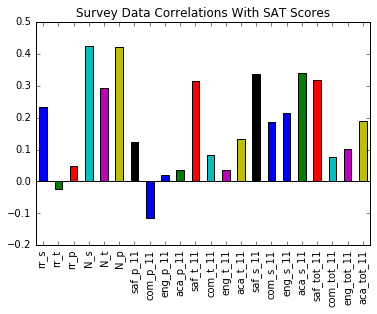

In [12]:
#create bar chart of 
%matplotlib inline
import matplotlib.pyplot as plt


#survey fields is defined above and we removed the "DBN" column
x=correlations[survey_fields].plot(kind="bar",title="Survey Data Correlations With SAT Scores")   
x.axhline(0,c="black")

Observation: Based on the bar chart displayed above, the items that are most correlated with sat_score are N_s and N_p. 

From the Data Dictionary on the city of NY's webiste, N_s is the number of student respondents and N_t is the number of parents respondents. 

Other variables with a strong correlation with sat_results are saf_s_11, aca_s_11, saf_t_11, and saf_tot_11 which represent the safety and respect scored based on students and teachers and the academic expectation score based on students. 

A parameter that has no correlation is eng_p_11 which is the engagement score based on parents.  

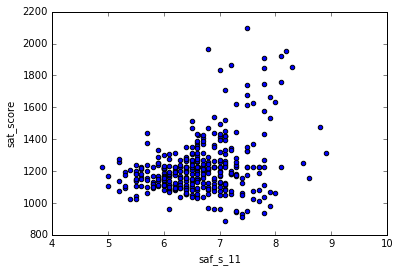

In [13]:
#explore the relationship between student's safety and sat_score
combined.plot.scatter(x="saf_s_11",y="sat_score")

Note: Safety scores (saf_s_11) probably range from 1-10. A majority of these values are within 5-8. 

Observation: It appears that scores increase dramatically in environments the students feel are safe. 

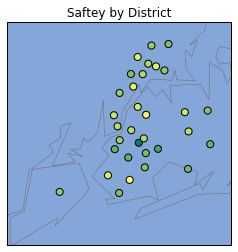

In [14]:
#view the average safety score for each district on a visualization
import numpy as np
districts=combined.groupby(combined["school_dist"]).agg(np.mean)
districts.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes=districts["lon"].tolist()
latitudes=districts["lat"].tolist()

#green for low numbers and yellow for high numbers
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=districts["saf_tot_11"],cmap="summer")
plt.title("Saftey by District")
plt.show()
        

Observation: In examining the map of average district safety, it appears the schools within Manhattan are the saftest in NYC.  

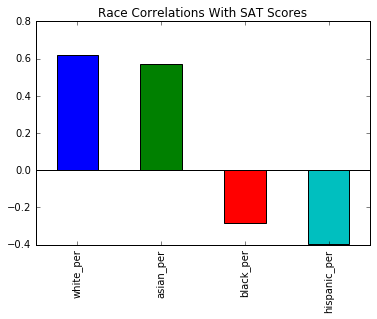

In [15]:
#investigate race versus SAT score 
races=["white_per","asian_per","black_per","hispanic_per"]
x=correlations[races].plot(kind="bar",title="Race Correlations With SAT Scores")   
x.axhline(0,c="black")

Observation: It appears that there is a strong positive correlation of white and asian % to average sat_scores where there is a negative correlation for black and hispanic % to average sat_scores. Race is a factor in SAT results. 

(0, 100)

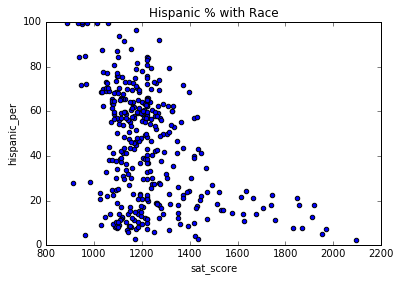

In [16]:
combined.plot.scatter(x="sat_score",y="hispanic_per",title="Hispanic % with Race")
plt.ylim(0,100)

Observation: A majority of the average scores are within 1000 - 1300 and take place for schools within 0 - 100% hispanic population. Beyond a score of 1500, the population percentage is less than 20%. 

In [17]:
#list of schools with over 95 percent hispanic 
combined.loc[combined["hispanic_per"]>95,"SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Observation: The schools with over 95% Hispanic population appear to be public schools welcoming to immigrants. Gregorio Luperon seemed like a great school focused on STEM subjects. 

In [18]:
#list of schools with over 95 percent hispanic 
combined.loc[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800),"SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Observation: The schools with SAT scores over 1800 and a Hispanic population less than 10% are all "specialized schools" that require a unique examination and audition process to attend. 

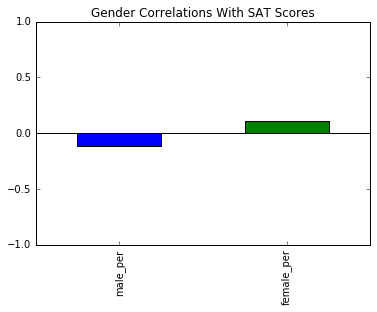

In [19]:
#investigate gender versus SAT score 
gender=["male_per","female_per"]
x=correlations[gender].plot(kind="bar",title="Gender Correlations With SAT Scores")   
x.set_ylim(-1,1)
x.axhline(0,c="black")

Obsevation: There really isn't a strong correlation as to whether males or females perform better on the SAT. 

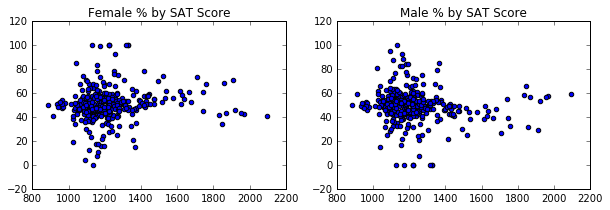

In [29]:
#view gender percentage versus SAT score
fig=plt.figure(figsize=(10,3))
Ax1=fig.add_subplot(1,2,1)
Ax1.scatter(combined["sat_score"],combined["female_per"])
Ax1.set_title("Female % by SAT Score")
Ax2=fig.add_subplot(1,2,2)
Ax2.scatter(combined["sat_score"],combined["male_per"])
Ax2.set_title("Male % by SAT Score")

plt.show()

Observation: There are a couple male and female schools which are single gender. A majority of the schools have 40 - 60% females within their student population with scores hovering between 1000-1400. There doesn't seem to be a correlation here between gender and SAT scores. 

In [43]:
#schools with over 60% females and SAT scores greater than 1700
combined.loc[(combined["female_per"]>60)&(combined["sat_score"]>1700),["SCHOOL NAME","Total Cohort"]]


,SCHOOL NAME,Total Cohort
5,BARD HIGH SCHOOL EARLY COLLEGE,139.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,127.0
60,BEACON HIGH SCHOOL,269.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,646.0
302,TOWNSEND HARRIS HIGH SCHOOL,278.0


Observation: The schools with high percentages of females and high test scores seem to be college prep schools with low average class counts. 

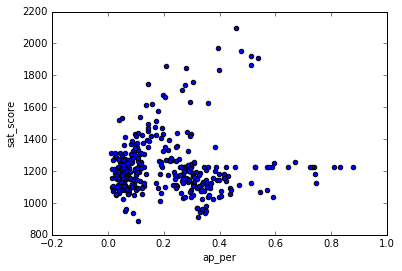

In [45]:
#view sat scores relationship with the percent of students that took AP exams
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter(x="ap_per",y="sat_score")

Observation: There appears to be two trends between percent of students that took AP tests and SAT scores. One trend shows that with an increase in percent that SAT scores increased. A second trend shows that with an increase in percent, scores stayed relatively the same. 

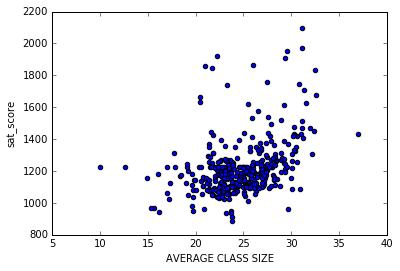

In [46]:
#class size with sat scores
combined.plot.scatter(x="AVERAGE CLASS SIZE",y="sat_score")

Obseration: This is interesting. I had expected that with a decrease in class size that average test scores would increase. The opposite is being shown in the above scatter plot. 

In [50]:
combined.info



<bound method DataFrame.info of Empty DataFrame
Columns: [DBN, SCHOOL NAME, Num of SAT Test Takers, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, sat_score, SchoolName, AP Test Takers , Total Exams Taken, Number of Exams with scores 3 4 or 5, Demographic, School Name, Cohort, Total Cohort, Total Grads - n, Total Grads - % of cohort, Total Regents - n, Total Regents - % of cohort, Total Regents - % of grads, Advanced Regents - n, Advanced Regents - % of cohort, Advanced Regents - % of grads, Regents w/o Advanced - n, Regents w/o Advanced - % of cohort, Regents w/o Advanced - % of grads, Local - n, Local - % of cohort, Local - % of grads, Still Enrolled - n, Still Enrolled - % of cohort, Dropped Out - n, Dropped Out - % of cohort, CSD, NUMBER OF STUDENTS / SEATS FILLED, NUMBER OF SECTIONS, AVERAGE CLASS SIZE, SIZE OF SMALLEST CLASS, SIZE OF LARGEST CLASS, SCHOOLWIDE PUPIL-TEACHER RATIO, Name, schoolyear, fl_percent, frl_percent, total_enrollment, prek, k, 